# TP2:Méthodes basées sur la théorie des valeurs extrêmes

Ce TP est une continuité du TP-1 dans lequel on souhaitait implémenter
la VaR (Value at Risk) et l’ES (Expected Shortfall) en utilisant les
méthodes classiques proposées dans la réglementation bâloise, i.e. la
méthode historique, paramétrique et bootstrap. Cependant, une limite de
ces méthodes est qu’elles ne prennent pas en compte la queue de
distribution de la perte. Pour remédier à cela, on peut utiliser des
méthodes avec la théorie des valeurs extrêmes, i.e. l’approche Block
Maxima et l’approche Peaks Over Threshold.

In [1]:
# Définition des librairies
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

/Users/cherylkouadio/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning:

urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020


In [2]:
# Import des données du CAC 40
data = yf.download("^FCHI")

# Calcul des rendements logarithmiques
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))

# Retirer la première ligne
data = data.dropna()

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

In [3]:
train = data[['log_return',"Close"]]['15-10-2008':'26-07-2022']
data_train = train['log_return']
neg_data_train = -data_train

test = data[['log_return',"Close"]]['27-07-2022':'11-06-2024']
data_test = test['log_return']
neg_data_test = -data_test

## I. Implémentation de la VaR avec la théorie des valeurs extrêmes

### I.1. VaR TVE : Approche Maxima par bloc

L’approche des Block Maxima (BM) est une méthode modélise les maxima des
rendements sur des blocs de taille fixe $s$ en utilisant la distribution
GEV. Le seuil de confiance $\alpha_{\text{GEV}}$ est ajusté pour
correspondre à l’horizon temporel de la VaR via la relation :

$$
\frac{1}{1-\alpha_{\text{VaR}}} = s \times \frac{1}{1-\alpha_{\text{GEV}}}.
$$

Nous allons dans ce projet une taille de blocs $s = 21$ jours ouvrés
comme ce qui souvent utilisé en pratique. De ce fait, nous parvenons à
construire 239 blocs de taille 21 et un bloc de taille De fait, la
Value-at-Risk sur un horizon 1 et pour un niveau de confiance \$ \_{}\$
est :

$$
\text{VaR}_h(\alpha_{\text{VaR}}) = G^{-1}_{(\hat \mu, \hat \sigma, \hat \xi)}(\alpha_{\text{GEV}}),
$$

où G est la fonction de répartition de la GEV
($\hat \mu, \hat \sigma, \hat \xi$) estimée.

### I.1.1. Construction de l’échantillon de maxima sur data_train

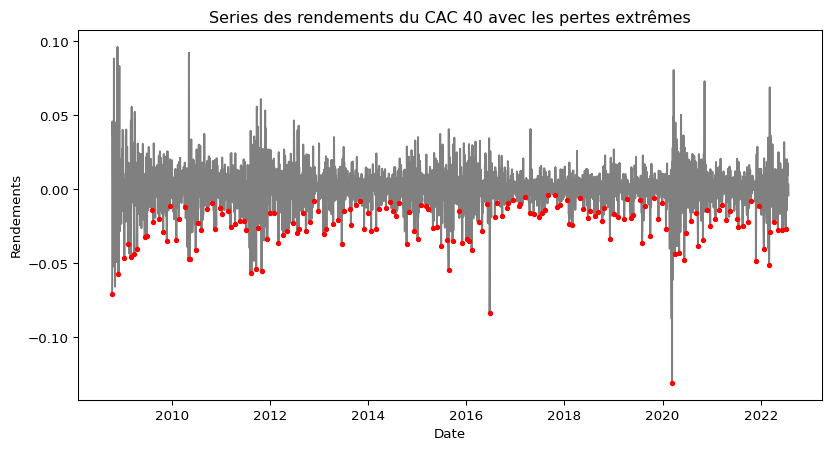

In [4]:
import numpy as np
import pandas as pd

def get_extremes(returns, block_size, min_last_block=0.6):
    """
    Extrait les valeurs extrêmes d'une série de rendements par blocs.
    
    Arguments :
    returns : pandas Series (index = dates, valeurs = rendements)
    block_size : int, taille du bloc en nombre de jours
    min_last_block : float, proportion minimale pour inclure le dernier bloc incomplet
    
    Retourne :
    maxima_sample : liste des valeurs maximales par bloc
    maxima_dates : liste des dates associées aux valeurs maximales
    """
    n = len(returns)
    num_blocks = n // block_size

    maxima_sample = []
    maxima_dates = []

    for i in range(num_blocks):
        block_start = i * block_size
        block_end = (i + 1) * block_size
        block_data = returns.iloc[block_start:block_end]  # Sélectionner le bloc avec les index

        max_value = block_data.max()
        max_date = block_data.idxmax()  # Récupérer l'index de la valeur max

        maxima_sample.append(max_value)
        maxima_dates.append(max_date)

    # Gestion du dernier bloc s'il reste des données suffisantes
    block_start = num_blocks * block_size
    block_data = returns.iloc[block_start:]

    if len(block_data) >= min_last_block * block_size:
        max_value = block_data.max()
        max_date = block_data.idxmax()
        
        maxima_sample.append(max_value)
        maxima_dates.append(max_date)
        
    return pd.Series(maxima_sample, index=maxima_dates)  # Retourner une Series avec les dates comme index


extremes = get_extremes(neg_data_train, block_size=21, min_last_block=0.6)

plt.figure(figsize=(10, 5))
plt.plot(data_train, color="grey")
plt.plot(-extremes,".", color="red") # 
plt.title("Series des rendements du CAC 40 avec les pertes extrêmes")
plt.xlabel("Date")
plt.ylabel("Rendements")
plt.show()

Pour avoir une idée de la distribution GEV de la serie des pertes
maximales de rendements du CAC 40 pour $s=21$, nous utilisons un Gumbel
plot qui est un outil graphique pour juger de l’hypothèse $\xi=0$,
i.e. la distribution GEV se réduit à la distribution de Gumbel.

Pour le construire, nous devons suivre les étapes suivantes :

1.  calculer l’abscisse avec la série des maximas ordonées
    $R_{(1)} \leq R_{(2)} \leq \ldots \leq R_{(n)}$.
2.  calculer l’ordonnée de la manière suivante :

$$
- log(-log(\frac{i - 0.5}{k})), \quad i = 1, \ldots, k.
$$

Lorsque la distribution adaptée est celle de Gumbel alors le Gumbel plot
est linéaire. Dans notre cas, nous constatons une courbure ce qui nous
pousse à conclure qu’une distribution Gumbel n’est pas adaptée dans la
modélisation des maxima des pertes de rendements du CAC 40. Une
distribution Fréchet ou de Weibull serait plus adaptée.

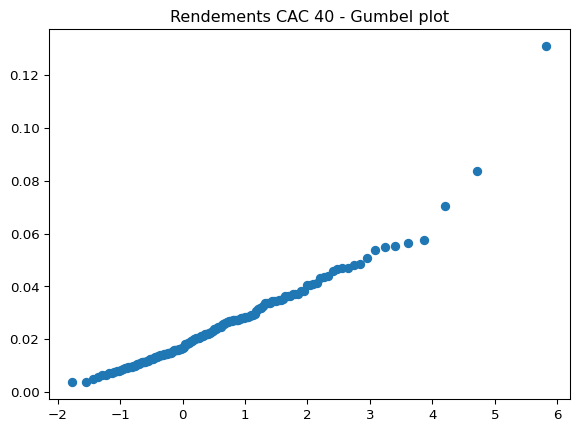

In [5]:
quantiles_theoriques_gumbel = []
k=len(extremes)
for i in range(1,len(extremes)+1):
    val = -np.log(-np.log((i-0.5)/k))
    quantiles_theoriques_gumbel.append(val)

# Tracer le Gumbel plot
plt.scatter(quantiles_theoriques_gumbel, np.sort(extremes), marker='o')
plt.title('Rendements CAC 40 - Gumbel plot')
plt.show()

### I.1.2. Estimation des paramètres de la loi de GEV

En estimant les paramètres de la loi GEV, nous utilisons la méthode du
maximum de vraisemblance. Les paramètres estimés par maximisation de la
fonction de vraisemblance sont les suivants
$\xi = -0.15, \mu=0.02, \sigma=0.01$. Nous constatons par ailleurs que
le paramètre de forme $\xi$ est négatif ce qui est cohérent avec notre
observation précédente.

In [6]:
from scipy.stats import genextreme as gev

params_gev = gev.fit(extremes)

shape, loc, scale = params_gev
# Afficher les paramètres estimés
print("="*50)
print("Paramètres estimés de la distribution GEV")
print("="*50)
print(f"Shape (xi) = {shape:.2f}")
print(f"Loc (mu) =  {loc:.2f}")
print(f"Scale (sigma) = {scale:.2f}")
print("="*50)

Paramètres estimés de la distribution GEV
Shape (xi) = -0.15
Loc (mu) =  0.02
Scale (sigma) = 0.01

Pour accorder plus de poids à cette observation, nous avons calculé un
intervalle de confiance profilé à 95% pour le paramètre de forme $\xi$.
Pour ce faire, nous avons suivi les étapes suivantes : 1. Estimation des
paramètres par maximum de vraisemblance : Nous avons estimé $\hat{\xi}$,
$\hat{\mu}$ et $\hat{\sigma}$ en maximisant la log-vraisemblance de la
loi GEV.

1.  Construction du profil de vraisemblance : Nous avons fixé $\xi$ à
    différentes valeurs autour de $\hat{\xi}$ et, pour chacune, réestimé
    $\mu$ et $\sigma$ afin d’obtenir une log-vraisemblance profilée.

2.  Seuil basé sur le test du rapport de vraisemblance : Le seuil
    critique est déterminé par la statistique \$ ^2(1) \$ :  
    $$
     \mathcal{L}_{\max} - \frac{\chi^2_{0.95, 1}}{2}
     $$

3.  Détermination des bornes de l’IC : L’intervalle est formé par les
    valeurs de $\xi$ pour lesquelles la log-vraisemblance reste
    au-dessus de ce seuil.

Cette approche permet une meilleure prise en compte de l’incertitude en
évitant les approximations asymptotiques classiques. La modélisation des
maxima des pertes de rendements du CAC 40 par une distribution de
Weibull serait plus adaptée.

Nous obtenons ainsi un intervalle de confiance à 95% pour le paramètre
de forme $\xi$ de $[-0.284, -0.039]$. Comme 0 n’appartient pas à cet
intervalle, nous pouvons rejeter l’hypothèse $\xi=0$. De ce fait, la
distribution de Weibull est plus adaptée pour modéliser les maxima des
pertes de rendements du CAC 40 car $\xi$ est négatif.

IC profilé pour shape: [-0.287, -0.042]

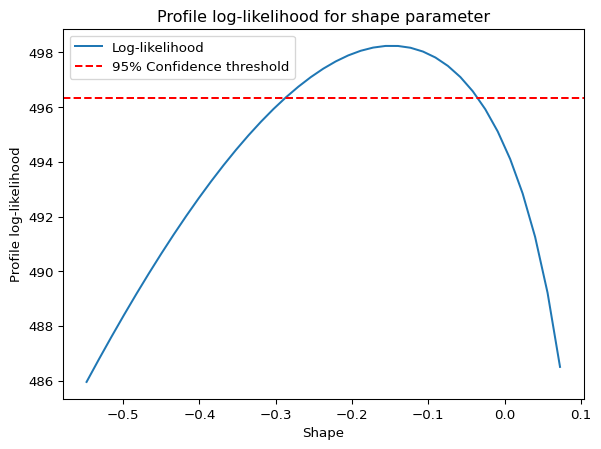

In [7]:
from scipy.optimize import minimize
from scipy.stats import chi2

# Fonction de log-vraisemblance
def gev_neg_log_likelihood(params, shape_fixed, data):
    """
    Calcule la log-vraisemblance négative de la distribution GEV
    en fixant le paramètre 'shape'.
    """
    loc, scale = params
    if scale <= 0:  # Contrainte pour éviter des valeurs invalides
        return np.inf
    return -np.sum(gev.logpdf(data, shape_fixed, loc=loc, scale=scale))

# Log-vraisemblance maximale
log_likelihood_max = -gev_neg_log_likelihood([loc, scale], shape, extremes)

# Calcul des IC profilés pour le paramètre shape
shape_grid = np.linspace(shape - 0.4, shape + 0.4, 50)  # Plage autour de la valeur estimée
profile_likelihood = []

for s in shape_grid:
    # Réoptimiser loc et scale en fixant shape
    result = minimize(
        gev_neg_log_likelihood,
        x0=[loc, scale],  # Initial guess for loc and scale
        args=(s, extremes),  # Fixer 'shape' à la valeur actuelle
        bounds=[(None, None), (1e-5, None)],  # Contraintes sur loc et scale
        method='L-BFGS-B'
    )
    if result.success:
        profile_likelihood.append(-result.fun)
    else:
        profile_likelihood.append(np.nan)

# Calcul du seuil pour les IC
chi2_threshold = log_likelihood_max - chi2.ppf(0.95, 1) / 2

# Déterminer les bornes des IC
profile_likelihood = np.array(profile_likelihood)
valid_points = np.where(profile_likelihood >= chi2_threshold)[0]
if len(valid_points) > 0:
    lower_bound = shape_grid[valid_points[0]]
    upper_bound = shape_grid[valid_points[-1]]
    print(f"IC profilé pour shape: [{lower_bound:.3f}, {upper_bound:.3f}]")
else:
    print("Impossible de déterminer des IC profilés avec les paramètres actuels.")

# Tracé du profil de log-vraisemblance
plt.plot(shape_grid, profile_likelihood, label="Log-likelihood")
plt.axhline(chi2_threshold, color='red', linestyle='--', label="95% Confidence threshold")
plt.xlabel("Shape")
plt.ylabel("Profile log-likelihood")
plt.title("Profile log-likelihood for shape parameter")
plt.legend()
plt.show()

#### a. Validation ex-ante

On remarque la loi GEV estimée par une weibull semble coller à la
distribution des rendements extrêmes du CAC 40. De plus, en utilisant un
QQ-plot, nous constatons que les quantiles théoriques de la GEV-Weibull
et empiriques sembelnt alignés sauf pour les quantiles élévés où l’on
constate un décrochage.

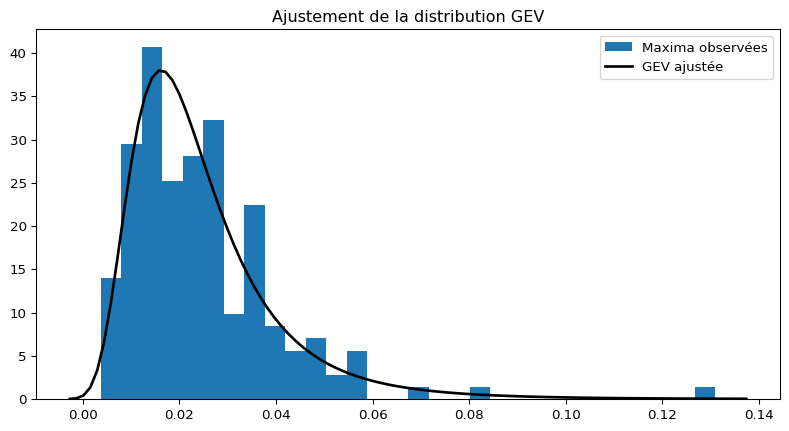

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(extremes, bins=30, density=True, label='Maxima observées')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_gev = gev.pdf(x, *params_gev)
plt.plot(x, p_gev, 'k', linewidth=2, label='GEV ajustée')
plt.title("Ajustement de la distribution GEV")
plt.legend()
plt.show()

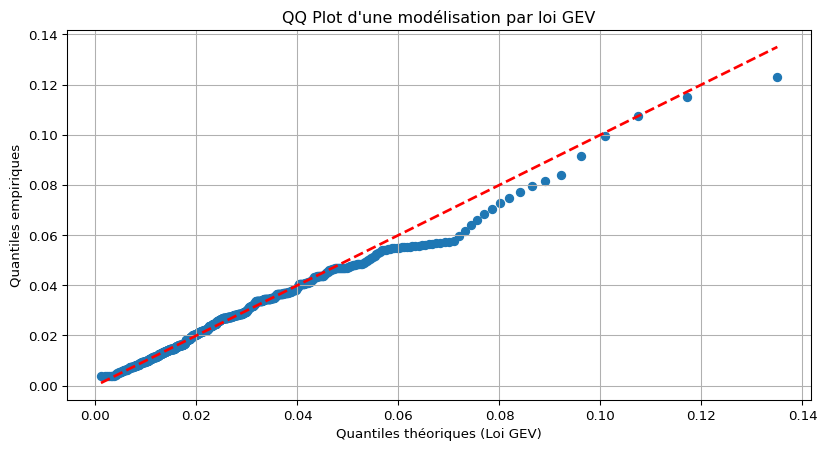

In [9]:
niveaux_quantiles = np.arange(0.001,1, 0.001)
quantiles_empiriques_TVE = np.quantile(extremes, niveaux_quantiles) 
quantiles_theoriques_GEV = gev.ppf(niveaux_quantiles, shape, loc = loc, scale = scale)

plt.figure(figsize=(10, 5))
plt.scatter(quantiles_theoriques_GEV, quantiles_empiriques_TVE)
plt.plot(quantiles_theoriques_GEV, quantiles_theoriques_GEV, color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.title("QQ Plot d'une modélisation par loi GEV")
plt.xlabel('Quantiles théoriques (Loi GEV)')
plt.ylabel('Quantiles empiriques')
plt.grid(True)
plt.show()

#### b. Calcul de la VaR TVE par MB

Pour calculer la VaR TVE pour un horizon de 1jour par MB, nous utilisons
la formule suivante :

$$
\text{VaR}_h(\alpha_{\text{VaR}}) = G^{-1}_{(\hat \mu, \hat \sigma, \hat \xi)}(\alpha_{\text{GEV}}),
$$

où G est la fonction de répartition de la
GEV$(\hat \mu, \hat \sigma, \hat \xi)$ estimée, et $\alpha_{\text{GEV}}$
est ajusté pour correspondre à l’horizon temporel de la VaR via la
relation :

$$
\frac{1}{1-\alpha_{\text{VaR}}} = s \times \frac{1}{1-\alpha_{\text{GEV}}}.
$$

Pour convertir la VaR à horizon 1jour en VaR à horizon T jours, la
méthode de scaling soulève quelques questions, car elle repose
essentiellement sur la normalité et l’indépendance des rendements ce qui
n’est pas le cas en pratique. De ce fait, nous utiliserons la méthode
alternative reposant sur la théorie des valeurs extrêmes.

y revenir

In [10]:
def BM_var(alpha,s,shape,loc,scale):
    """
    Calcul de la VaR gaussienne
    alpha : le niveau de confiance de la VaR
    s : le nombre de jours dans un bloc
    """
    alpha_bm = 1-s*(1-alpha)

    return gev.ppf(alpha_bm, shape, loc = loc, scale = scale),alpha_bm

alpha = 0.99
var_BM_train,alpha_bm = BM_var(0.99, 21, shape, loc, scale)

print(f"La VaR TVE pour h=1j et alpha={alpha} est : {var_BM_train:.4%}")
print(f"La VaR TVE pour h=10j et alpha={alpha} est : {(10**alpha_bm)*var_BM_train:.4%}")

La VaR TVE pour h=1j et alpha=0.99 est : 3.3274%
La VaR TVE pour h=10j et alpha=0.99 est : 20.5167%

### I.1.3. Estimation des paramètres de la loi de EV

Bien que l’intervalle de confiance à 95% pour le paramètre de forme
$\xi$ de $[-0.284, -0.039]$ ne contienne pas 0, nous avons tout de même
estimé les paramètres de la loi EV pour comparer les résultats avec ceux
de la loi GEV. En estimant tout de même les paramètres de la loi EV,
nous obtenons les paramètres suivants : $\mu=0.02, \sigma=0.01, \xi=0$.

Nous constatons que la loi EV ne semble pas mal s’adapter à la
distribution des rendements extrêmes du CAC 40.

In [11]:
from scipy.stats import gumbel_r

params_gumbel = gumbel_r.fit(extremes)

# Afficher les paramètres estimés
print("="*50)
print("Paramètres estimés de la distribution GEV GUMBEL")
print("="*50)
print(f"Loc (mu) =  {params_gumbel[0]:.2f}")
print(f"Scale (sigma) = {params_gumbel[1]:.2f}")
print("="*50)

Paramètres estimés de la distribution GEV GUMBEL
Loc (mu) =  0.02
Scale (sigma) = 0.01

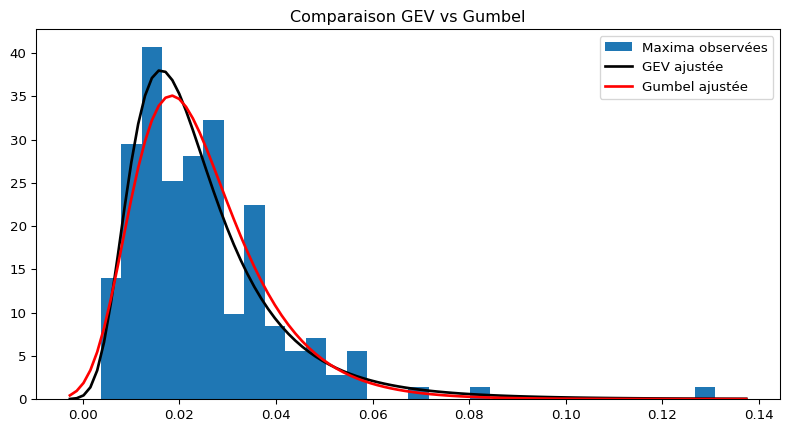

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(extremes, bins=30, density=True, label='Maxima observées')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Densité GEV ajustée
p_gev = gev.pdf(x, *params_gev)
plt.plot(x, p_gev, 'k', linewidth=2, label='GEV ajustée')

# Densité Gumbel ajustée
p_gumbel = gumbel_r.pdf(x, *params_gumbel)
plt.plot(x, p_gumbel, 'r', linewidth=2, label='Gumbel ajustée')
title = "Comparaison GEV vs Gumbel"
plt.title(title)
plt.legend()
plt.show()

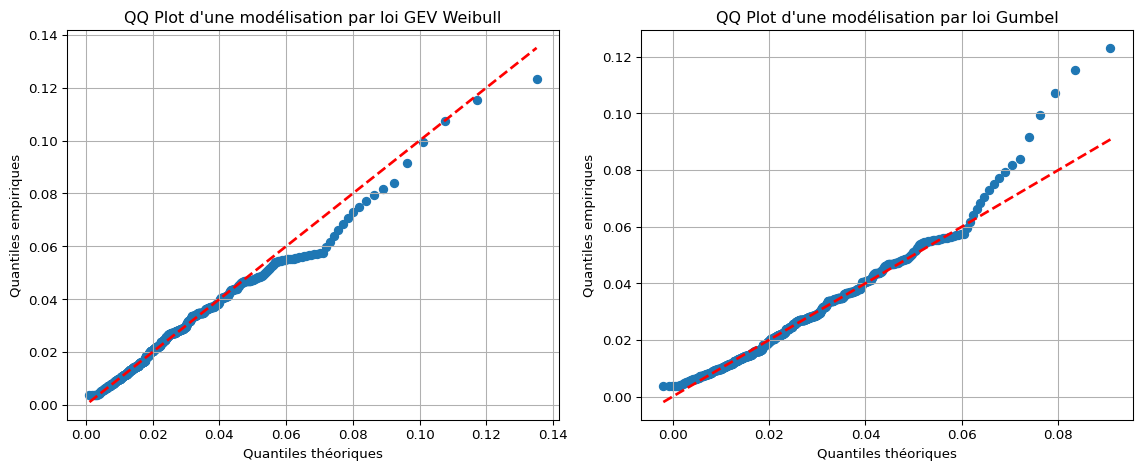

In [13]:
quantiles_theoriques_Gumb = gumbel_r.ppf(niveaux_quantiles, *params_gumbel)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(quantiles_theoriques_GEV, quantiles_empiriques_TVE)
plt.plot(quantiles_theoriques_GEV, quantiles_theoriques_GEV, color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.title("QQ Plot d'une modélisation par loi GEV Weibull")
plt.xlabel('Quantiles théoriques')
plt.ylabel('Quantiles empiriques')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.scatter(quantiles_theoriques_Gumb, quantiles_empiriques_TVE)
plt.plot(quantiles_theoriques_Gumb, quantiles_theoriques_Gumb, color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.title("QQ Plot d'une modélisation par loi Gumbel")
plt.xlabel('Quantiles théoriques')
plt.ylabel('Quantiles empiriques')
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
alpha = 0.99
var_BM_train,alpha_bm = BM_var(0.99, 21, shape=0, loc=params_gumbel[0], scale=params_gumbel[1])

print(f"La VaR TVE Gumbel pour h=1j et alpha={alpha} est : {var_BM_train:.4%}")
print(f"La VaR TVE Gumbel pour h=10j et alpha={alpha} est : {(10**alpha_bm)*var_BM_train:.4%}")

La VaR TVE Gumbel pour h=1j et alpha=0.99 est : 3.3513%
La VaR TVE Gumbel pour h=10j et alpha=0.99 est : 20.6638%

De plus, les résultats en terme de VaR sont très proches entre les deux
modèles.

## I.2. VaR TVE : Approche Peak over threshold

### I.2.1. Choix du seuil u

Cette méthode est basée sur la modélisation de la distribution des excès
au-dessus d’un seuil élevé de log-rendement négatif ($u$), seuil
déterminé de manière subjective à partir de l’analyse du mean residual
life plot, en ajustant une distribution de Pareto généralisée (GPD).
Dans le mean residual life plot, si les excès au-delà de 𝒖 suivent une
loi GPD, alors le mean-excess plot a un comportement linéaire. On
cherche alors la valeur du seuil \$\$ pour laquelle le mean-excess plot
est linéaire. Nous ne privilégions pas les seuils $u$ élevés puisque la
moyenne est faite sur peu d’observations.

Nous allons choisir un seuil $u = 0.03$ pour lequel le mean residual
life plot est linéaire. Nous allons ensuite ajuster une distribution GPD
pour les excès au-dessus de ce seuil.

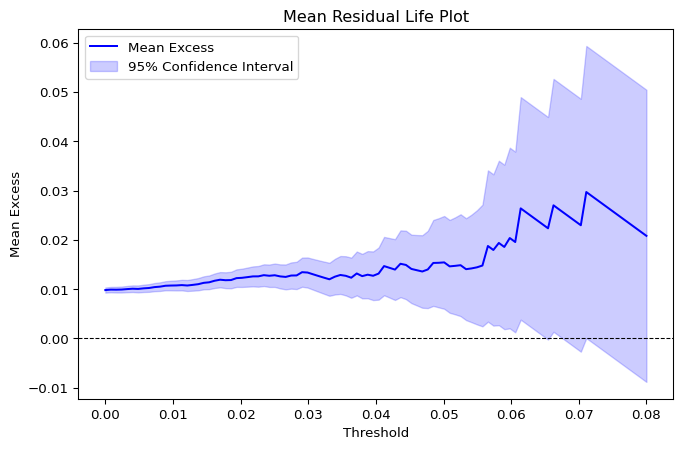

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, genpareto

def mean_residual_life_plot(data, tlim=None, pscale=False, nt=100, conf=0.95, return_values=False):
    """
    Trace le Mean Residual Life (MRL) Plot pour identifier un seuil optimal pour une GPD.

    Paramètres :
    - data : array-like, données d'entrée.
    - tlim : tuple (min, max), limites des seuils (si None, calculé automatiquement).
    - pscale : bool, si True, utilise des quantiles au lieu de valeurs absolues.
    - nt : int, nombre de seuils à considérer.
    - conf : float, niveau de confiance pour l'intervalle (ex: 0.95 pour 95%).

    Retourne :
    - Un graphique MRL avec l'intervalle de confiance.
    """

    # Trier et filtrer les données
    data = np.sort(data[~np.isnan(data)])
    nn = len(data)
    if nn <= 5:
        raise ValueError("Les données contiennent trop peu de valeurs valides.")

    # Définition des seuils
    if tlim is None:
        tlim = (data[0], data[nn - 5])  # Évite les 4 plus grandes valeurs

    if np.all(data <= tlim[1]):
        raise ValueError("La borne supérieure du seuil est trop élevée.")

    if pscale:
        # Travailler en quantiles au lieu de valeurs absolues
        tlim = (np.mean(data <= tlim[0]), np.mean(data <= tlim[1]))
        pvec = np.linspace(tlim[0], tlim[1], nt)
        thresholds = np.quantile(data, pvec)
    else:
        thresholds = np.linspace(tlim[0], tlim[1], nt)

    # Initialiser les résultats
    mean_excess = np.zeros(nt)
    lower_conf = np.zeros(nt)
    upper_conf = np.zeros(nt)

    # Calcul du Mean Excess et de l'IC
    for i, u in enumerate(thresholds):
        exceedances = data[data > u] - u  # Excès au-dessus du seuil
        if len(exceedances) == 0:
            mean_excess[i] = np.nan
            lower_conf[i] = np.nan
            upper_conf[i] = np.nan
            continue
        
        mean_excess[i] = np.mean(exceedances)
        std_dev = np.std(exceedances, ddof=1)
        margin = norm.ppf((1 + conf) / 2) * std_dev / np.sqrt(len(exceedances))
        
        lower_conf[i] = mean_excess[i] - margin
        upper_conf[i] = mean_excess[i] + margin

    # Tracé du Mean Residual Life Plot
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, mean_excess, label="Mean Excess", color='blue')
    plt.fill_between(thresholds, lower_conf, upper_conf, color='blue', alpha=0.2, label=f"{conf*100:.0f}% Confidence Interval")
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel("Threshold" if not pscale else "Threshold Probability")
    plt.ylabel("Mean Excess")
    plt.title("Mean Residual Life Plot")
    plt.legend()
    plt.show()
    if return_values:
        return thresholds, mean_excess, lower_conf, upper_conf

mean_residual_life_plot(neg_data_train, tlim=[0,0.08])

# regarder quantile à 5%

### I.2.2. Estimation des paramètres de la loi GPD

En estimant les paramètres de la loi GPD, nous utilisons la méthode du
maximum de vraisemblance. Les paramètres estimés par maximisation de la
fonction de vraisemblance sont les suivants
$\xi = 1.33, \mu \approx 0.00, \sigma=0.01$. De ce fait, la distribution
de Pareto généralisée est adaptée pour modéliser les excès au-dessus du
seuil $u = 0.03$.

In [16]:
u = 0.03
excess_values = [value - u for value in neg_data_train if value >= u]

from scipy.stats import genpareto

params_gpd = genpareto.fit(excess_values)

# Afficher les paramètres estimés
print("Paramètres estimés de la distribution GPD:")
print(f"Shape (xi) = {params_gpd[0]:.2f}")
print(f"Localisation (mu) = {params_gpd[1]:.2f}")
print(f"Echelle (sigma) = {params_gpd[2]:.2f}")

Paramètres estimés de la distribution GPD:
Shape (xi) = 1.33
Localisation (mu) = 0.00
Echelle (sigma) = 0.01

### I.2.3. Validation ex-ante

En comparant la distribution GPD estimée et la distribution empirique
des excès, nous constatons que la distribution ne semble pas
correspondre. De plus, le QQ-plot estimé indique que les quantiles
théoriques de la loi GPD sont beaucoup plus grands que les quantiles
empiriques observés dans notre distribution des excès. Nous concluons
que la distribution GPD n’est pas adaptée pour modéliser les excès
au-dessus du seuil $u = 0.03$. Cela peut être dû à un mauvais choix du
seuil $u$, une analyse plus aprofondie aurait été nécessaire pour
choisir un seuil plus adapté.

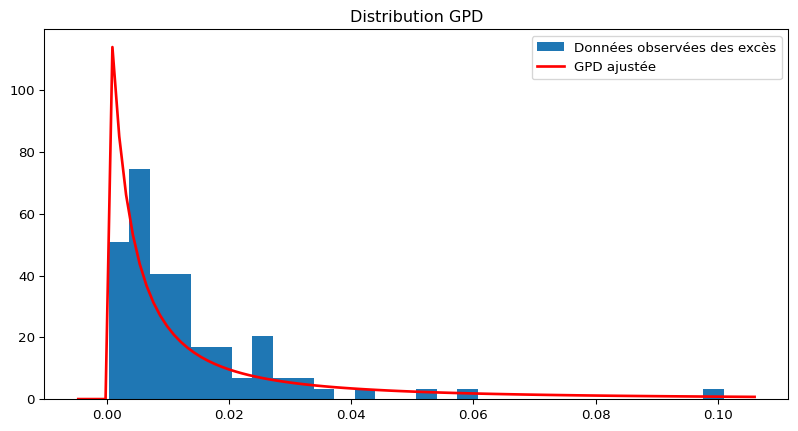

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(excess_values, bins=30, density=True, label='Données observées des excès')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Densité GPD ajustée
p_gpd = genpareto.pdf(x, *params_gpd)
plt.plot(x, p_gpd, 'r', linewidth=2, label='GPD ajustée')

title = "Distribution GPD"
plt.title(title)
plt.legend()
plt.show()

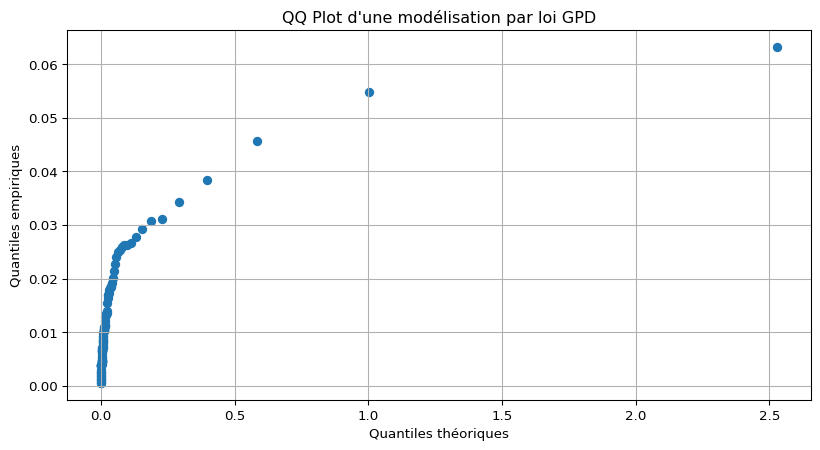

In [18]:
niveaux_quantiles = np.arange(0.01, 1, 0.01)
quantiles_empiriques_POT = np.quantile(excess_values, niveaux_quantiles)
quantiles_theoriques_GDP = genpareto.ppf(niveaux_quantiles, *params_gpd)

plt.figure(figsize=(10, 5))

plt.scatter(quantiles_theoriques_GDP, quantiles_empiriques_POT)
plt.title("QQ Plot d'une modélisation par loi GPD")
plt.xlabel('Quantiles théoriques')
plt.ylabel('Quantiles empiriques')
plt.grid(True)
plt.show()

### I.2.3. Calcul de la VaR POT par POT

La Value-at-Risk sur un horizon 1 jour et pour un niveau de confiance
${\alpha}$ est alors obtenue par la formule :

$$
\text{VaR}_h(\alpha) = \hat{H}_{(\hat{\sigma}, \hat{\xi}) }(\alpha_{\text{POT}})^{-1} + u,
$$

où $\hat{H}(\hat{\sigma}, \hat{\xi})$ est la fonction de répartition de
la GPD($\hat{\sigma},\hat{\xi}$) estimée, $\alpha_{\text{POT}}$ est le
quantile ajusté, nécessaire pour adapter le calcul de la VaR dans le
cadre de la distribution GPD.

Comme on ne se concentre que sur l’échantillon des excès dans cette
modélisation, l’estimation de la VaR à partir de la GPD ne doit pas se
faire au niveau $\alpha$, mais à un niveau ajusté $\alpha_{\text{POT}}$
défini par la relation suivante :

$$
1 - \alpha_{\text{POT}} = \frac{n}{N_u} \times (1 - \alpha),
$$

où $n$ représente le nombre total d’observations, $N_u$ correspond au
nombre d’excès au-delà du seuil $u$,

In [19]:
def POT_var(data,alpha,u,shape,loc,scale):
    """
    Calcul de la VaR gaussienne
    alpha : le niveau de confiance de la VaR
    s : le nombre de jours dans un bloc
    """
    n = len(data)
    excess_values = [value - u for value in data if value >= u]
    nu = len(excess_values)

    alpha_pot = 1-n*(1-alpha)/nu

    return genpareto.ppf(alpha_pot, shape, loc = loc, scale = scale) + u,alpha_pot

alpha = 0.99
var_POT_train,alpha_pot = POT_var(neg_data_train, alpha, u,*params_gpd)

print(f"La VaR TVE pour h=1j et alpha={alpha} est : {var_POT_train:.4%}")
print(f"La VaR TVE pour h=10j et alpha={alpha} est : {(10**alpha_pot)*var_POT_train:.4%}")

La VaR TVE pour h=1j et alpha=0.99 est : 4.3634%
La VaR TVE pour h=10j et alpha=0.99 est : 17.3572%